Data description
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

Age | Objective Feature | age | int (days)
Height | Objective Feature | height | int (cm) |
Weight | Objective Feature | weight | float (kg) |
Gender | Objective Feature | gender | categorical code |
Systolic blood pressure | Examination Feature | ap_hi | int |
Diastolic blood pressure | Examination Feature | ap_lo | int |
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
Smoking | Subjective Feature | smoke | binary |
Alcohol intake | Subjective Feature | alco | binary |
Physical activity | Subjective Feature | active | binary |
Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
All of the dataset values were collected at the moment of medical examination.

In [170]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, confusion_matrix, classification_report, plot_roc_curve

In [171]:
df = pd.read_csv("../input/cardiovascular-disease-dataset/cardio_train.csv", sep = ";")

In [172]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x :'% 3f' % x)

In [173]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.000000,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.000000,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.000000,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.000000,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.000000,100,60,1,1,0,0,0,0


First look at the data

In [174]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [175]:
check_df(df)

##################### Shape #####################
(70000, 13)
##################### Types #####################
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object
##################### Head #####################
   id    age  gender  height     weight  ap_hi  ap_lo  cholesterol  gluc  \
0   0  18393       2     168  62.000000    110     80            1     1   
1   1  20228       1     156  85.000000    140     90            3     1   
2   2  18857       1     165  64.000000    130     70            3     1   
3   3  17623       2     169  82.000000    150    100            1     1   
4   4  17474       1     156  56.000000    100     60            1     1   

   smoke  alco  active  cardio  
0      0     0       1       0  
1  

In [176]:
df = df.drop('id', axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.000000,110,80,1,1,0,0,1,0
1,20228,1,156,85.000000,140,90,3,1,0,0,1,1
2,18857,1,165,64.000000,130,70,3,1,0,0,0,1
3,17623,2,169,82.000000,150,100,1,1,0,0,1,1
4,17474,1,156,56.000000,100,60,1,1,0,0,0,0


In [177]:
#convert it to age by years
df["age"] = round(df["age"] / 365)

In [178]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.000000,2,168,62.000000,110,80,1,1,0,0,1,0
1,55.000000,1,156,85.000000,140,90,3,1,0,0,1,1
2,52.000000,1,165,64.000000,130,70,3,1,0,0,0,1
3,48.000000,2,169,82.000000,150,100,1,1,0,0,1,1
4,48.000000,1,156,56.000000,100,60,1,1,0,0,0,0


**DATA PREP & EDA**

Adjust thresholds and check the outliers

In [179]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [180]:
def check_outlier(dataframe, col_name, q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

We were able to separate the variables in the data set as categorical and numerical.

In [181]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

Which features have outliers?

In [182]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

for col in num_cols:
    print(col, check_outlier(df, col))

Observations: 70000
Variables: 12
cat_cols: 7
num_cols: 5
cat_but_car: 0
num_but_cat: 7
age False
height True
weight True
ap_hi True
ap_lo True


Replacing outliers with upper and lower limit

In [183]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [184]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [185]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
height False
weight False
ap_hi False
ap_lo False


In [186]:
df.isnull().values.any()

False

In [187]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.000000,2,168.000000,62.000000,110.000000,80.000000,1,1,0,0,1,0
1,55.000000,1,156.000000,85.000000,140.000000,90.000000,3,1,0,0,1,1
2,52.000000,1,165.000000,64.000000,130.000000,70.000000,3,1,0,0,0,1
3,48.000000,2,169.000000,82.000000,150.000000,100.000000,1,1,0,0,1,1
4,48.000000,1,156.000000,56.000000,100.000000,60.000000,1,1,0,0,0,0


**Feature Engineering**

In [188]:
df.loc[(df["age"] < 18), "NEW_AGE"] = "Young"
df.loc[(df["age"] > 18) & (df["age"] < 56), "NEW_AGE"] = "Mature"
df.loc[(df["age"] >= 56), "NEW_AGE"] = "Old"

In [189]:
cols1 = df["weight"]
cols2 = df["height"] / 100

In [190]:
df["bmi"] = (cols1) / (cols2)**2

In [191]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,NEW_AGE,bmi
0,50.000000,2,168.000000,62.000000,110.000000,80.000000,1,1,0,0,1,0,Mature,21.967120
1,55.000000,1,156.000000,85.000000,140.000000,90.000000,3,1,0,0,1,1,Mature,34.927679
2,52.000000,1,165.000000,64.000000,130.000000,70.000000,3,1,0,0,0,1,Mature,23.507805
3,48.000000,2,169.000000,82.000000,150.000000,100.000000,1,1,0,0,1,1,Mature,28.710479
4,48.000000,1,156.000000,56.000000,100.000000,60.000000,1,1,0,0,0,0,Mature,23.011177


In [192]:
df.loc[(df["bmi"] < 18.5), "NEW_BMI"] = "under"
df.loc[(df["bmi"] >= 18.5) & (df["bmi"] <= 24.99) ,"NEW_BMI"] = "healthy"
df.loc[(df["bmi"] >= 25) & (df["bmi"] <= 29.99) ,"NEW_BMI"]= "over"
df.loc[(df["bmi"] >= 30), "NEW_BMI"] = "obese"

In [ ]:
df["ap_hi"].max()

In [193]:
df.loc[(df["ap_lo"])<=89, "BLOOD_PRESSURE"] = "normal"
df.loc[(df["ap_lo"])>=90, "BLOOD_PRESSURE"] = "hyper"
df.loc[(df["ap_hi"])<=120, "BLOOD_PRESSURE"] = "normal"
df.loc[(df["ap_hi"])>120, "BLOOD_PRESSURE"] = "normal"
df.loc[(df["ap_hi"])>=140, "BLOOD_PRESSURE"] = "hyper"

In [194]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,NEW_AGE,bmi,NEW_BMI,BLOOD_PRESSURE
0,50.000000,2,168.000000,62.000000,110.000000,80.000000,1,1,0,0,1,0,Mature,21.967120,healthy,normal
1,55.000000,1,156.000000,85.000000,140.000000,90.000000,3,1,0,0,1,1,Mature,34.927679,obese,hyper
2,52.000000,1,165.000000,64.000000,130.000000,70.000000,3,1,0,0,0,1,Mature,23.507805,healthy,normal
3,48.000000,2,169.000000,82.000000,150.000000,100.000000,1,1,0,0,1,1,Mature,28.710479,over,hyper
4,48.000000,1,156.000000,56.000000,100.000000,60.000000,1,1,0,0,0,0,Mature,23.011177,healthy,normal


In [198]:
df.groupby('age')['cardio'].mean()

age
30.000000    0.000000
39.000000    0.222494
40.000000    0.231111
41.000000    0.271540
42.000000    0.293064
43.000000    0.388406
44.000000    0.358125
45.000000    0.381770
46.000000    0.401015
47.000000    0.462865
48.000000    0.468065
49.000000    0.443815
50.000000    0.406114
51.000000    0.436202
52.000000    0.471620
53.000000    0.471926
54.000000    0.493153
55.000000    0.544059
56.000000    0.542364
57.000000    0.549587
58.000000    0.565065
59.000000    0.567528
60.000000    0.602196
61.000000    0.649468
62.000000    0.671676
63.000000    0.713583
64.000000    0.716071
65.000000    0.687500
Name: cardio, dtype: float64

In [197]:
df.groupby("smoke")["cardio"].mean()

smoke
0    0.502107
1    0.474793
Name: cardio, dtype: float64

In [200]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

Using the label encoder for data types object and unique values equal to 2

In [201]:
# label encoder
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col].astype(str))
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2]

for col in df.columns:
    label_encoder(df, col)

Using one-hot-encoder for categorical cols

In [216]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= len(df[col].unique()) > 2]

one_hot_encoder(df, ohe_cols, drop_first=True).head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,NEW_AGE,bmi,BLOOD_PRESSURE,cholesterol_1,cholesterol_2,gluc_1,gluc_2,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_BMI_4
0,-0.400000,1,0.272727,-0.493333,-0.500000,0.000000,0,0,1,0,0,705,1,0,0,0,0,0,0,0,0
1,0.100000,0,-0.818182,0.813333,1.000000,1.000000,0,0,1,1,0,2528,0,0,1,0,0,0,1,0,0
2,-0.200000,0,0.000000,-0.360000,0.500000,-1.000000,0,0,0,1,0,927,1,0,1,0,0,0,0,0,0
3,-0.600000,1,0.363636,0.600000,1.500000,-5.100000,0,0,1,1,0,1716,0,0,0,0,0,0,0,1,0
4,-0.600000,0,-0.818182,-0.800000,-1.000000,-2.000000,0,0,0,0,0,854,1,0,0,0,0,0,0,0,0


Scale the data,

I used RobustScaler because it robust the outliers

In [203]:
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

Define the target variable and features,
Split the data by train and test. Test size is 20% and train size is 80%

In [204]:
y = df["cardio"]
X = df.drop(["cardio"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=1)

Build the model and train

In [205]:
log_model = LogisticRegression().fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluate the success of the model with train set

In [206]:
# Train Accuracy
y_pred = log_model.predict(X_train)
accuracy_score(y_train, y_pred)

0.7181607142857143

In [207]:
y_prob = log_model.predict_proba(X_test)[:, 1]

y_pred = log_model.predict(X_test)

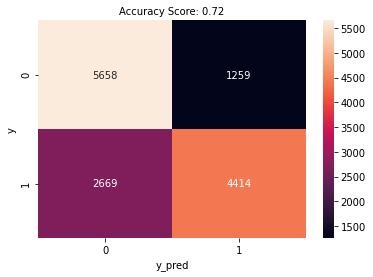

In [208]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y_test, y_pred)

Evaluate the model accuracy with test set

In [209]:
accuracy_score(y_test, y_pred)

0.7194285714285714

In [210]:
precision_score(y_test, y_pred)

0.7780715670720959

In [211]:
recall_score(y_test, y_pred)

0.6231822674008188

In [212]:
f1_score(y_test, y_pred)

0.6920664785199121

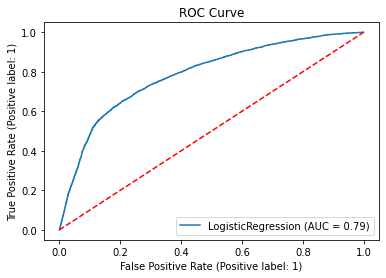

In [213]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [214]:
roc_auc_score(y_test, y_prob)

0.7853580271724325

In [215]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      6917
           1       0.78      0.62      0.69      7083

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

